In [1]:
import numpy as np
import GPy
import matplotlib.pyplot as plt
from tqdm import trange
from scipy.stats import norm, beta
from scipy.optimize import minimize, differential_evolution

Напомним, что реализация black-box'а - это случайная величина, распределённая как $p(t|f(x),\theta_1,...,\theta_n)$. Регрессия с не-гауссовской такой случайной величиной (соответственно, с не-гауссовским likelihood'ом) не получается, или же работает странно. 

In [2]:
RANK = 1 # Раземерность куба, на котором определена наша функция
L = np.array([6]) # Куб будет со стороной 2*L и центром в 0

Истинная функция - подкорректированная (т.ч. её значения > 0) функция Михалевича 

In [3]:
def f(x):
    y = 0
    for i in range(RANK):
        y = y + np.sin(x[:, i]) * np.sin(x[:, i]**2 / np.pi)
    return (y + 1)*10

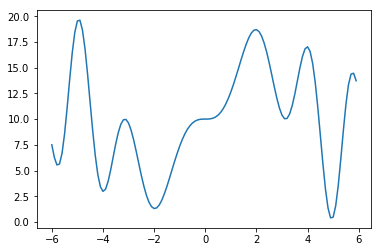

In [4]:
x = np.arange(-L,L,0.1).reshape(-1,RANK)
plt.plot(x, f(x))
plt.show()

# Poisson distribution

В этом случае $f(x)$ - Это параметр $\lambda$

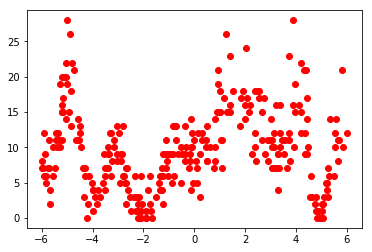

In [5]:
def generate_value(f, x):
    return np.random.poisson(f(x), size=x.shape[0]).reshape(x.shape[0], 1)

x = np.random.uniform(-L,L,[300,1])
y = generate_value(f,x)
plt.plot(x,y,'ro')
plt.show()

In [6]:
X = np.random.uniform(-L, L, [600,RANK])
Y = generate_value(f, X)
kernel = GPy.kern.RBF(1, variance=1)

In [7]:
poisson = GPy.likelihoods.Poisson()
model = GPy.core.GP(X, Y, kernel=kernel, 
                              inference_method=GPy.inference.latent_function_inference.laplace.Laplace(),
                              likelihood=poisson)

In [8]:
model.optimize()

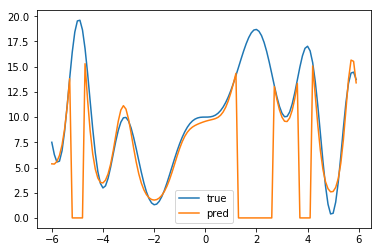

In [9]:
x = np.arange(-L,L,0.1).reshape(-1,1)
y = model.predict(x)[0]
plt.plot(x, f(x), label='true')
plt.plot(x,y, label='pred')
plt.legend()
plt.show()

Мы видим странные провалы, которые не лечатся игрой с variance в kernel'е.

# Exponential distribution

В этом случае $f(x)$ - Это параметр $\lambda$

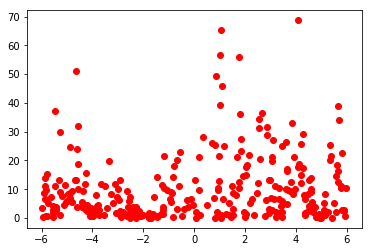

In [10]:
def generate_value(f, x):
    return np.random.exponential(f(x), size=x.shape[0]).reshape(x.shape[0], 1)

x = np.random.uniform(-L,L,[300,1])
y = generate_value(f,x)
plt.plot(x,y,'ro')
plt.show()

In [11]:
X = np.random.uniform(-L, L, [600,RANK])
Y = generate_value(f, X)
kernel = GPy.kern.RBF(1, variance=1)

In [12]:
exponential = GPy.likelihoods.Exponential()
model = GPy.core.GP(X, Y, kernel=kernel,
                              inference_method=GPy.inference.latent_function_inference.laplace.Laplace(),
                              likelihood=exponential)

In [13]:
model.optimize()

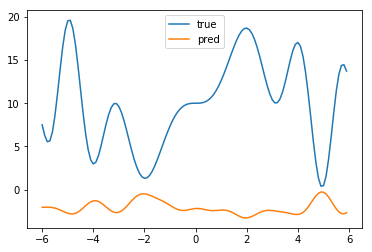

In [14]:
x = np.arange(-L,L,0.1).reshape(-1,1)
y = model._raw_predict(x)[0]
plt.plot(x, f(x), label='true')
plt.plot(x,y, label='pred')
plt.legend()
plt.show()

В случае этого распределения метод predict у объекта GPy.core.GP (т.е. у модели) перестаёт работать. Метод же _raw_predict (найденный в сурцах) выдаёт неадекватный ответ. 

# Binomial distribution

Подкрутим $f(x)$ так, чтобы она принимала значения от 0 до 1 (т.к. $f(x)$ - это параметр $p$ биномиального распределения)

In [15]:
def f(x):
    y = 0
    for i in range(RANK):
        y = y + np.sin(x[:, i]) * np.sin(x[:, i]**2 / np.pi)
    return (y + 1)/2

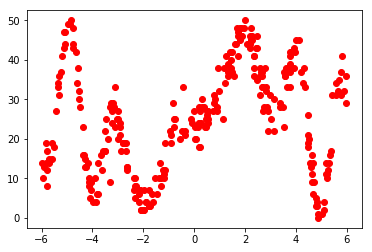

In [16]:
def generate_value(f, x):
    return np.random.binomial(50, f(x), size=x.shape[0]).reshape(x.shape[0], 1)

x = np.random.uniform(-L,L,[300,1])
y = generate_value(f,x)
plt.plot(x,y,'ro')
plt.show()

In [17]:
X = np.random.uniform(-L, L, [600,RANK])
trials = np.ones(X.shape, dtype='int') * 50
Y = generate_value(f, X)
kernel = GPy.kern.RBF(1, variance=1)

In [18]:
binomial = GPy.likelihoods.Binomial()
model = GPy.core.GP(X, Y, kernel=kernel, 
                              Y_metadata={'trials': trials},
                              inference_method=GPy.inference.latent_function_inference.Laplace(),
                              likelihood=binomial)

In [19]:
model.optimize()

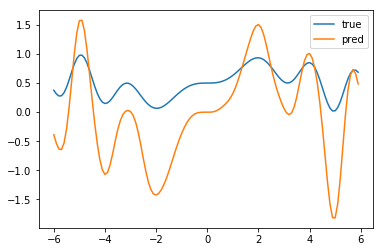

In [20]:
x = np.arange(-L,L,0.1).reshape(-1,1)
trials = np.ones(x.shape, dtype='int')*50
y = model._raw_predict(x)[0]
plt.plot(x, f(x), label='true')
plt.plot(x,y, label='pred')
plt.legend()
plt.show()

Метод predict не работает и здесь, _raw_predict же выдаёт растянутый и сдвинутый ответ относительно истинного